# Example 1

## Problem

$$(OCP)_1\left\{\begin{array}{l}
Min \int_0^{t_f}x\sqrt{1+u^2}dt\\
\dot{x} = u\\
u\in\R
\end{array}
\right.$$

In [1]:
# Packages

using Pkg
Pkg.activate(".")
#
using OptimalControl
using LinearAlgebra
using ForwardDiff
using DifferentialEquations
using Roots     # solve an equation f(x)=0 where f is from R to R
# using MINPACK # NLE solver 
# using NLsolve
using LaTeXStrings

using Test

  Activating project at `~/control-toolbox/indirect`


## Control-toolbox definition of the problem

In [2]:
using OptimalControl   
t0 = 0
tf = 2
x0 = 1
xf = 1
@def ocp begin
    t ∈ [ t0, tf ], time
    x ∈ R, state
    u ∈ R, control
    x(t0) == x0
    x(tf) == xf
    ẋ(t) ==  u(t)
    ∫(x(t)*(1 + u(t)^2)^(1/2)) → min
end


┌───────┬───────┬─────────┬──────────┬───────────┬─────────────┐
│ times │ state │ control │ dynamics │ objective │ constraints │
├───────┼───────┼─────────┼──────────┼───────────┼─────────────┤
│    ✅ │    ✅ │      ✅ │       ✅ │        ✅ │          ✅ │
└───────┴───────┴─────────┴──────────┴───────────┴─────────────┘


t ∈ [t0, tf], time
x ∈ R, state
u ∈ R, control
x(t0) == x0
x(tf) == xf
ẋ(t) == u(t)
∫(x(t) * (1 + u(t) ^ 2) ^ (1 / 2)) → min


## Hamiltonian flow
The Hamiltonian is
$$H(x,u,p) =  -x\sqrt{1+u^2} + up,$$
and for $|p| < |x|$ the maximization of the Hamiltonian have the solution
$$u(x,p) = sign(x)p\sqrt{1. /(x^2-p^2)}.$$
Then the true Hamiltonian is $H_r(x,p)=H(x,u(x,p),p)$. 

We note $z(t) = (x(t),p(t))$, then the hamiltonian flow is the function
$\phi(.,z_0) = \phi(.,x_0,p_0)$ solution of the initial value problem
$$(IVP)\left\{
\begin{array}{l}
\dot{z} = \vec{H}(z) = \begin{pmatrix}
\dot{x}\\ \dot{p}
\end{pmatrix} =
\begin{pmatrix}
\dfrac{\partial H(z)}{\partial p}\\
-\dfrac{\partial H(z)}{\partial x}
\end{pmatrix}\\
z(0) = z_0 = (x_0,p_0).
\end{array}
    \right.$$

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase /Users/gergaud/.julia/packages/SciMLBase/eK30d/src/performance_warnings.jl:32


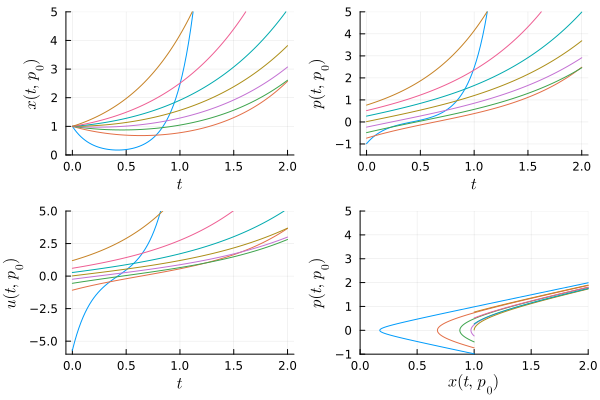

In [3]:
# Compute the  Flow

u(x, p) = sign(x[1])*p[1]*sqrt(1. /(x[1]^2-p[1]^2))  # contol function

# the Flow function of the control-toolbox package computes the hamiltonian flow
ocp_flow = Flow(ocp, u)  # ocp_flow.ode_sol is the result of the solve function from the DifferentailEquations package

# Compute flows for different value of the initial costate $p_0
Int_p0 = -0.985:0.25:0.98   # intervalle of p_0
Δt = (tf - t0)/100          # 
plt_x = plot()          # plot of the state x(t)
plt_p = plot()          # plot of the costate p(t)
plt_u = plot()          # plot of the control u(t)
plt_phase = plot()      # plot (x,p)

for p0 in Int_p0        # plot for each p_0 in Int_p0 
    flow_p0 = ocp_flow((t0, tf), x0, p0, reltol = 1e-8, abstol = 1e-8, saveat = Δt)
    T = flow_p0.ode_sol.t
    X = flow_p0.ode_sol[1,:]
    P = flow_p0.ode_sol[2,:]
    par = atanh(p0./x0)
    plot!(plt_x,T,X)
    plot!(plt_p,T,P)
    plot!(plt_u,T,u.(X,P))  
    plot!(plt_phase,X,P)      
end

# Plots
plot!(plt_x,xlabel = L"t",ylabel=L"x(t,p_0)",legend=false, ylims=(0.,5.))
plot!(plt_p,xlabel = L"t",ylabel=L"p(t,p_0)",legend=false, ylims=(-1.5,5.))
plot!(plt_u,xlabel = L"t",ylabel=L"u(t,p_0)",legend=false, ylims=(-6.,5.))
plot!(plt_phase,xlabel = L"x(t,p_0)",ylabel=L"p(t,p_0)",legend=false, xlims=(0.,2.), ylims=(-1.,5.))
plot(plt_x,plt_p,plt_u,plt_phase,layout = (2,2))

## Conjugate points
The time $\tau$ is said to be conjugate to the the time $t_0=0$ if the solution of the Jacobi equation
$$
\dot{\delta z}(t) = \dfrac{\partial \vec{H}}{\partial z}(z(t,z_0))\delta z(t)
$$
with the initial condition
$\delta z(0) = \begin{pmatrix}0\\1
\end{pmatrix}$, is vertical at time $\tau$, that is $\delta x(\tau) = 0$.

We first compute by automatic differentiation the flow of the Jacobi equation with the initial condition 
$$\delta z(t,x_0,p_0)=\dfrac{\partial z}{\partial p_0}z(t,x_0,p_0)$$ 


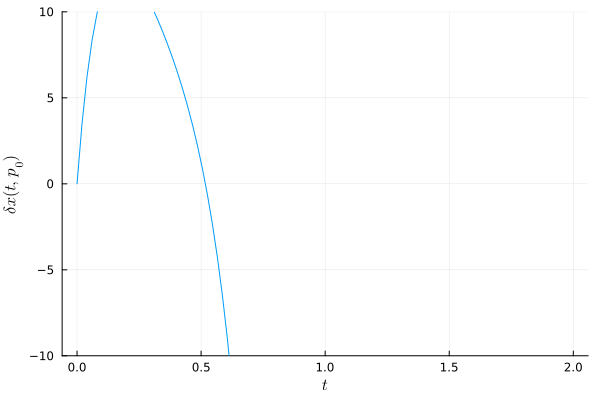

In [4]:
#
# Conjugate points
#
include("./example1-analytique.jl")   # contains functions for unitary tests 

"""
    Compute the flow of the Jacobi equation for the initial condition δz(0) = (0,1)
    sol = flow_jacobi(T,x0,p0)
    input : 
    T : time where we want δz(t) 
        list or array (t0,t1,...,tN)
    x0 : initial state
         Real(n), here a real
    p0 : initial costate
         Real(n), here a real
    output : 
    sol : (δz(t0),δz(t1),...,δz(tN))
          Vector of vector of dimension 2n, the type of the element are the same as the type of p0 because we use after the automatic differentiation.
          To modifie if n > 1

"""
function flow_jacobi(T,x0,p0)
    n = length(x0)
    t0 = T[1]
    nb_t = length(T)
    # type because we use ForwardDiff
    sol = [Vector{typeof(p0[1])}(undef,2n) for _ in 1:nb_t] # Vector -> Matrix if n >  1
                                                         # typeof(p0) -> typeof(p0[1]), type of the element of p0
    for i in 1:nb_t
        t = T[i]
        # flow_p0 compute de flow at t oh the hamiltonian system
        flow_p0(p_0) = ocp_flow((t0, t), x0, p_0, reltol = 1e-10, abstol = 1e-10).ode_sol.u[end]
        # temp is the solution at t of the derivative with respect to p0 of the flow
        temp = ForwardDiff.derivative(flow_p0, p0)  # p0 is a real
        #sol[i] = det(temp[1:n,1:n])
        sol[i] = temp
    end
    return sol
end

p0 = -0.985
t0tf = (0., 2.)

@test isapprox(flow_jacobi(t0tf,x0,p0)[end] ,flow_jacobi_ana(t0tf,x0,p0).u[end]; rtol = 1.e-3)

Int_t0tf = range(t0,stop=tf,length=100)
sol = flow_jacobi(Int_t0tf,x0,p0)
plt_conj1 = plot()
plot!(plt_conj1,Int_t0tf,[sol[i][1] for i in 1:length(sol)])  # as n=1 the det is the number
plot!(plt_conj1,xlabel = L"t",ylabel=L"\delta x(t,p_0)",legend=false, ylims=(-10.,10.))
plot(plt_conj1)


Then we numerically compute the conjugate point by solving $\delta x(t)=\delta z(t,x_0,p_0)_1=0$, for $x_0=1.$ and $p_0=0.985$.

For p0 = -0.985 tau_0 = 0.51728931341542


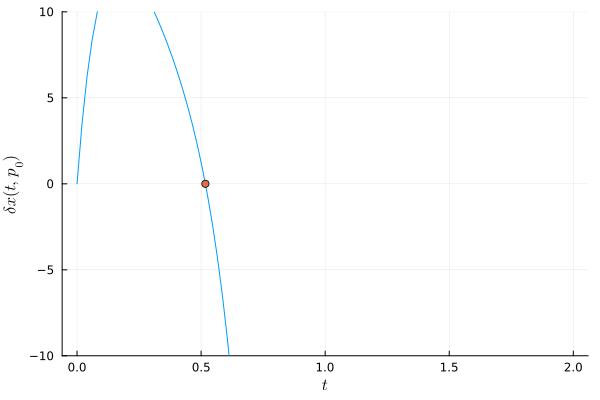

In [5]:
# compute the fisrt conjugate point
function F(t0,τ,x0,p0)
    tspan = (t0,τ)
#    return [flow_jacobi(tspan,x₀,p0)(τ)[1]]
    return flow_jacobi(tspan,x0,p0)[end]
end

# compute τ0
δx(τ) = F(t0,τ,x0,p0)[1]

#sol = nlsolve(δx,[0.5])
using Roots
#τ0 = sol.zero
τ0 = find_zero(δx, (0.4, 0.6))
println("For p0 = ", p0, " tau_0 = ", τ0)

plot!(plt_conj1,[τ0],[flow_jacobi((t0,τ0),x0,p0)[end]],seriestype=:scatter)

## Compute the conjugate loci
We compute conjugate loci by path following algorithm

We define $F(\tau,p_0) = \delta x(\tau,p_0)$ and we suppose that 
$\dfrac{\partial F}{\partial\tau}(\tau,p_0)$ is  inversible, then by the implicit function theorem the conjugate time is a function of $p_0$. So, as here $p_0\in\R$, we can compute them by solving the initial value problem
$$(IVP_{conj.points})\left\{
\begin{array}{l}
\dot{\tau} = -\dfrac{\partial F}{\partial\tau}(\tau,p_0)^{-1}\dfrac{\partial F}{\partial p_0}(\tau,p_0)\\
\tau(p_0) = \tau_0.
\end{array}
    \right.$$

### Remark
The derivative $\dfrac{\partial F}{\partial\tau}(\tau,p_0) = \dfrac{\partial \delta x}{\partial\tau}(\tau,p_0)$ is equal to  the first component of the second member of the Jacobi equation
$\dfrac{\partial \vec{H}}{\partial z}(z(t,z_0))\delta z(t)$.


x0 = 1.0, p0 = -0.985
p0 = -0.985


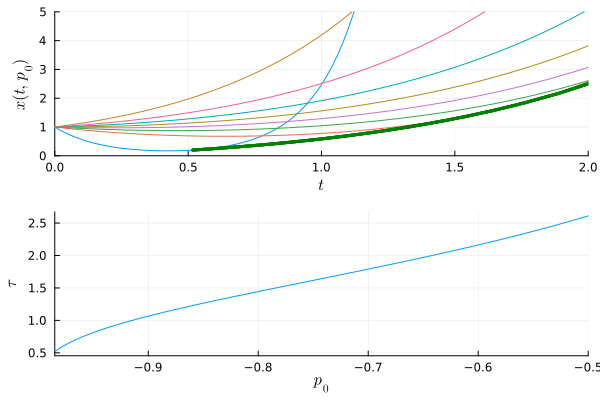

In [9]:
    # Test of Hvec 
    Hvec! = ocp_flow.rhs! # 
    #z0 = [1.,-0.1]
    par = 0.
    z0 = [x0 , p0]
    zpoint = similar(z0)
    Hvec!(zpoint,z0,par,t0)
    atol = 1.e-12
    @test  zpoint ≈ H_vec(z0) atol = atol   # test for the Hvec! function

# 


#conjugates points by path following
"""
    Compute the right hanf side of the conj.points IVP equation
    tau_point = rhs_path(tau , par, p0)
    For the structure of the rhs_path see DifferentialEquaions  package
"""
function rhs_path(tau , par, p0)
    n = length(p0)
    τ = tau[1]     # tau is a vector
    z0 = [x0,p0]
    Hvec!(zpoint,z0) = ocp_flow.rhs!(zpoint,z0,par,τ)
    Hvec!(zpoint,z0)     # zpoint is the second member of the Hamiltonian flow
    dHvec = Matrix{typeof(p0[1])}(undef,2n,2n) #zeros(2*n,2*n)
    z = ocp_flow((t0, τ), x0, p0, reltol = 1e-8, abstol = 1e-8).ode_sol(τ) # compute z(τ)
    # Compute matrix \dfrac{\partial \vec{H}}{\partial z}(z(t,z_0)) : the first part of the rhs of the variational equation 
    ForwardDiff.jacobian!(dHvec,Hvec!,zpoint,z) 
    δz = flow_jacobi((t0,τ),x0,p0)[end]
    derivee_τ = (dHvec*δz)[1]    # #derivative w.r.t. τ

    Ftau(p0) = F(t0,τ,x0,p0)[1] # First componant of the flow of the Jacobi equation at τ
    derivee_p0 = ForwardDiff.derivative(Ftau, p0) #derivative w.r.t. p0  
    return [-(1/derivee_τ)*derivee_p0]
end

p0=-0.985
τ = 0.5
x0 = 1.
rhs_jacobi = rhs_path(0.5 , 1., p0)
println("x0 = ", x0, ", p0 = ", p0)


@test isapprox(rhs_path(0.5 , 1., p0),rhs_path_ana(0.5 , 1., p0); rtol = 1.e-7)


function conj_point(p0span, τ0)
    pb = ODEProblem(rhs_path,[τ0],p0span,[1.])
    sol = DifferentialEquations.solve(pb, reltol = 1e-8, abstol = 1e-8)
    return sol
end

# conjugate point

println("p0 = ", p0)

p0span = (p0, -0.5)
sol = conj_point(p0span,τ0)
plt_conj_point = plot(sol,xlabel = L"p_0", ylabel = L"\tau")
TT = sol.u
nb_t = length(sol.t)
T = zeros(nb_t)
X = zeros(nb_t)
for i in 1:nb_t
    T[i] = TT[i][1]
    X[i] = x(T[i][1],x0,sol.t[i])
end

plot!(plt_x,T,X,linewidth=3,color = :green, legend=false, xlims=(0.,2.0), ylims=(0.,5.))
plot(plt_x,plt_conj_point,layout = (2,1),legend=false)